In [1]:
import os
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

cross correlation , elastix, fsl flirt (degrees of freedom), jacobian determinant

In [2]:
# constants
dirname = "data/9003126/T2/"

In [3]:
# functions
def get_slice(filename):
    ds = pydicom.dcmread(filename)  # plan dataset
    ds.PatientName

    shape = ds.pixel_array.shape

    # Convert to float to avoid overflow or underflow losses.
    image_2d = ds.pixel_array.astype(float)

    vmax = 2697.0 # TODO -- this should be max across all images
    
    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / vmax) * 255.0

    # Convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)
    return image_2d_scaled, ds.AcquisitionTime

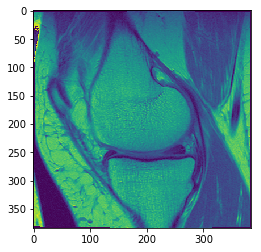

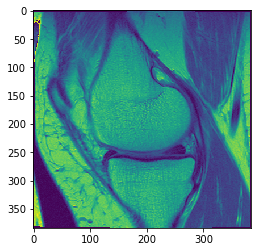

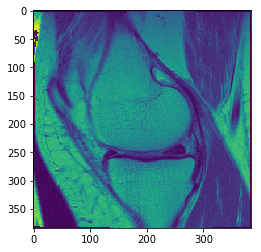

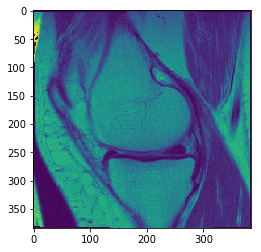

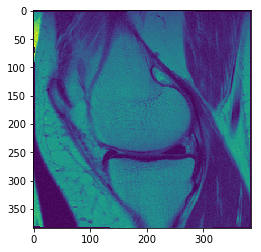

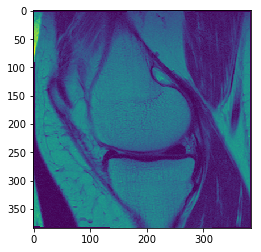

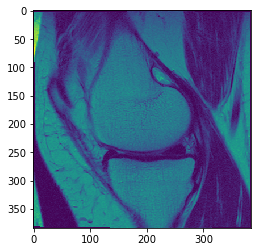

In [4]:
for i in range(7):
    img, _ = get_slice(dirname + '%03d' % (i*29+20))
    plt.imshow(img)
    plt.show()

# Tutorial - registration

In [5]:
from dipy.data import get_fnames
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools

In [6]:
from dipy.align import imwarp

In [7]:
fname_moving = get_fnames('reg_o')
fname_static = get_fnames('reg_c')

moving = np.load(fname_moving)
static = np.load(fname_static)

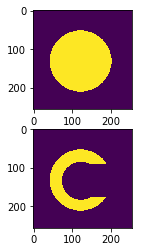

In [8]:
plt.subplot(211)
plt.imshow(moving)
plt.subplot(212)
plt.imshow(static)

In [9]:
metric = SSDMetric(static.ndim)

In [10]:
level_iters = [200, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)
mapping = sdr.optimize(static, moving)

Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
Optimizing level 1


/Users/dominik/anaconda3/envs/mri/lib/python2.7/site-packages/dipy/align/imwarp.py:985: RuntimeWarning: invalid value encountered in sqrt
  mean_norm = np.sqrt(sq_field).mean()


Optimizing level 0


(array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  127.        ,  127.00000763, ...,    0.        ,
          127.        ,  127.        ],
        [   0.        ,  127.00000763,  127.        , ...,    0.        ,
          127.        ,  127.        ],
        ..., 
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  127.        ,  127.        , ...,    0.        ,
          127.        ,  127.        ],
        [   0.        ,  127.        ,  127.        , ...,    0.        ,
          127.        ,  127.        ]], dtype=float32),
 array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  126.87220764,  126.88522339, ...,    0.        ,
          127.        ,  127.        ],
        [   0.        ,  126.86068726,  127.        , ...

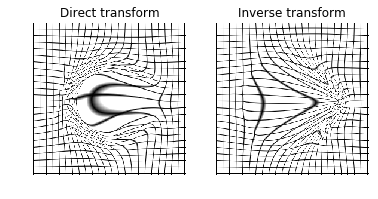

In [11]:
regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

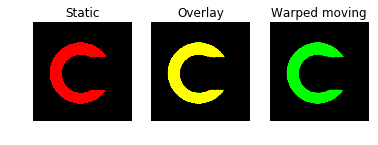

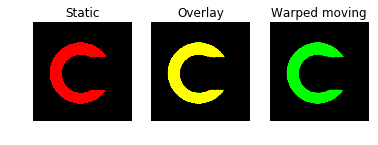

In [12]:
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Static','Overlay','Warped moving',
   'direct_warp_result.png')

# My attempt registration

In [29]:
img1, _ = get_slice(dirname + '%03d' % (0*29+1))
img2, _ = get_slice(dirname + '%03d' % (6*29+1))

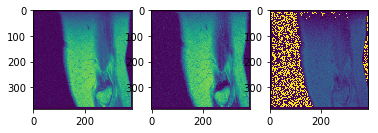

In [30]:
plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(abs(img1-img2))

In [31]:
metric = CCMetric(img1.ndim)
level_iters = [200, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)
mapping = sdr.optimize(img1, img2)

Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0


In [32]:
img2al = mapping.transform(img2)

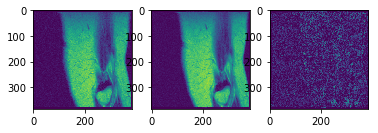

In [33]:
plt.subplot(131)
plt.imshow(img2)
plt.subplot(132)
plt.imshow(img2al)
plt.subplot(133)
plt.imshow(abs(img2al-img2))

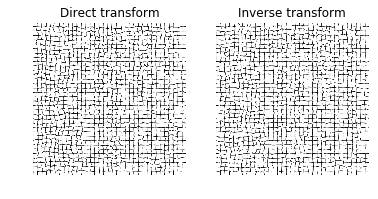

In [34]:
trans, inv_trans = regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

In [ ]:
CCMetric?

In [ ]:
SSDMetric?

In [ ]:
EMMetric?

In [18]:
from dipy.align import metrics 

# My attempt fitting

In [35]:
def read_t2_weighted(slice_idx=1):
    vec_t2 = []
    vec_time = []
    for i in range(7):
        im_, tm = get_slice(dirname + '%03d' % (i*29 + slice_idx))
        vec_t2.append(im_)
        vec_time.append(float(tm))
    return np.asarray(vec_t2), np.asarray(vec_time)

In [44]:
scan, time = read_t2_weighted()

We want to fit:

$$
S_{TE} = S_0 \exp{(-TE/T2)}
$$

In other form:

$$
\log S_{TE} = \log S_0 - TE \frac{1}{T2}
$$



In [37]:
te = np.array([10., 15., 20., 25., 30., 35., 40.])
t2 = 40.
s0 = 100.

measurements = s0 * np.exp(-te/t2)

In [38]:
x0 = np.ones_like(te)

In [39]:
y = np.log(measurements)
x = np.concatenate((x0[:, np.newaxis], -te[:, np.newaxis]), 1)

In [40]:
import scipy.linalg as la

In [41]:
beta, _, _, _ = la.lstsq(x, y)

In [42]:
s0_ = np.exp(beta[0])
t2_ = 1/beta[1]

s0_, t2_

(100.00000000000004, 39.999999999999943)

In [82]:
data = np.log(scan+0.0000000001)

In [112]:
x = np.concatenate((np.ones_like(time[..., np.newaxis]), -time[..., np.newaxis]), 1)

In [84]:
x

array([[  1.00000000e+00,  -8.09592050e+04],
       [  1.00000000e+00,  -8.09592150e+04],
       [  1.00000000e+00,  -8.09592250e+04],
       [  1.00000000e+00,  -8.09592350e+04],
       [  1.00000000e+00,  -8.09592450e+04],
       [  1.00000000e+00,  -8.09592550e+04],
       [  1.00000000e+00,  -8.09592650e+04]])

In [93]:
data[:,ix,iy]==data[0,ix,iy]

array([ True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [111]:
scan.shape

(7, 384, 384)

In [99]:
matt2 = np.zeros((data.shape[1], data.shape[2]))
exps = []
for ix in range(data.shape[2]):
    for iy in range(data.shape[2]):
        if all(data[:,ix,iy]==data[0,ix,iy]):
            matt2[ix, iy] = 0
            continue
        beta, _, _, _ = la.lstsq(x,data[:,ix,iy])
        exps.append(data[:,ix,iy])
        s0_ = np.exp(beta[0])
        t2_ = 1/beta[1]
        matt2[ix, iy] = t2_

In [95]:
matt2[np.where(matt2 == np.inf)] = 0

(array([   8425.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

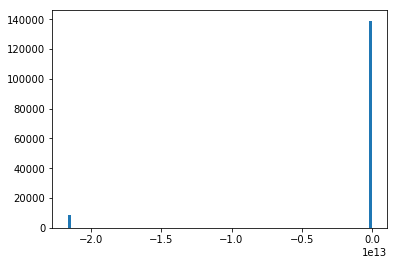

In [96]:
plt.hist(matt2.flatten(),bins=100)

In [97]:
matt2.flatten().min()

-21658719568309.074

In [79]:
#matt2[np.where(matt2==np.inf)] = 0
matt2[np.where(matt2>np.percentile(matt2.flatten(), 99))]=0
matt2[np.where(matt2<0)]=0

In [80]:
np.max(matt2)

0.46037734527222157

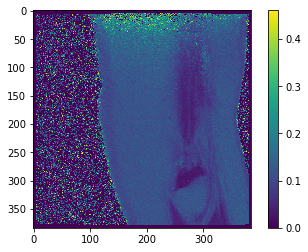

In [81]:
plt.imshow(matt2)
plt.colorbar()

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

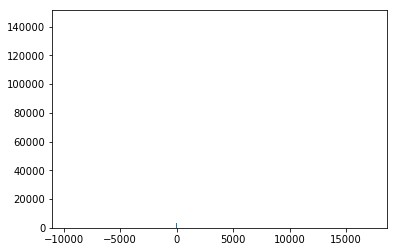

In [79]:
plt.hist(matt2.flatten(),bins=1000)

In [56]:
data[:,300,200]

array([ 5.23046875,  5.33203125,  5.171875  ,  5.07421875,  4.9140625 ,
        4.94140625,  4.7890625 ], dtype=float16)

In [57]:
beta, _, _, _ = la.lstsq(x, data[:,300,200])

In [59]:
1./beta

array([  1.46295119e-06,   1.18440287e-01])

In [73]:
time[2]-time[1]

0.010018000000854954